In [ ]:
import sys, urllib.request

IS_COLAB = 'google.colab' in sys.modules

    
if IS_COLAB:
    from google.colab import files
    
    #create extra folders
    !mkdir -pv data images models

    # will install missing packages if running in colab
    if 'uproot' not in sys.modules:
        print('Installing uproot...')
        !pip install uproot

    #will download the data if running in colab
    urllib.request.urlretrieve('https://cernbox.cern.ch/index.php/s/GRAyoFxBHAlMVpu/download',
                               'data/events_6D64x64.root')
    urllib.request.urlretrieve('https://cernbox.cern.ch/index.php/s/dZ9r1nvBRTpJMNW/download',
                               'data/events_6D64x64_ATLAS_resolution_6D64x64.root')
    print('ls data')
    !ls data/*

    #download additional modules used with the notebook
    !wget https://raw.githubusercontent.com/mpitt82/AI/master/ParticleImages/train_helpers.py
    !wget https://raw.githubusercontent.com/mpitt82/AI/master/ParticleImages/particleImages_helpers.py

    print('Using COLAB: all additional packages are installed and the data is downloaded')

# Super resolution notebook

In this notebook, the Super Resolution (SR) will be applied on the detector images. The goal is to reconstruct detector images with higher resolution. In this notebook we will try several approaches for this task.

The input data obtained using the [ATLAS-simplified](https://github.com/mpitt82/Geant4-models/tree/master/ATLAS-simplified) Geant4 simulation model. The bare data files are available [here](https://cernbox.cern.ch/index.php/s/oCg3en1GHAvYSTo?path=%2FCalo_RectangularGeo_diPion64x64%2Frun).

Using the [Vector2Matrix.cc](https://github.com/mpitt82/Geant4-models/blob/master/ATLAS-simplified/scripts/Vector2Matrix.cc) script $6\times 64\times 64$ images are obtaned, then with [Matrix2Matrix6L.cc](https://github.com/mpitt82/Geant4-models/blob/master/ATLAS-simplified/scripts/Matrix2Matrix6L.cc) script Low-resolution images are computed. For democtaric upsaling (used as a first approach) the [Matrix2Matrix6L.cc](https://github.com/mpitt82/Geant4-models/blob/master/ATLAS-simplified/scripts/Matrix6L2Matrix.cc) script can be used. **NOTE** All scripts executed in [CINT](https://root.cern.ch/cint). 


Standards imports

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

### Loading the data

In this example, we will use two example files from cernbox folder, which have $\sim$2k events.

In [2]:
inputfileHR = 'data/events_6D64x64.root'
inputfileLR = 'data/events_6D64x64_ATLAS_resolution_6D64x64.root'

f = uproot.open(inputfileHR)
treeHR = f['EventTree']

f = uproot.open(inputfileLR)
treeLR = f['EventTree']

print('Total number of events in both files is = '+str(treeHR.numentries)+' (HR) and '+str(treeLR.numentries)+' (LR)')

Total number of events in both files is = 2100 (HR) and 2100 (LR)


### Calorimeter images

In this section, we will create calorimeter images from the cell hits using LR and HR input files. First we will constract a dataset using SRDataLoader defined in [train_helpers.py](train_helpers.py)

In [3]:
from train_helpers import SRDataLoader

In [103]:
q, w= train_dataset[3:5]

In [107]:
q.shape

(2, 6, 64, 64)

In [108]:
q = torch.Tensor(q)

In [109]:
torch.cat([q,q],dim=1).shape

torch.Size([2, 12, 64, 64])

In [4]:
#for now we will use the full data to validate the model
train_dataset = SRDataLoader(treeLR, treeHR)
test_dataset  = SRDataLoader(treeLR, treeHR)

Draw a random image from the energy matrices:

In [5]:
from particleImages_helpers import DrawEventSR

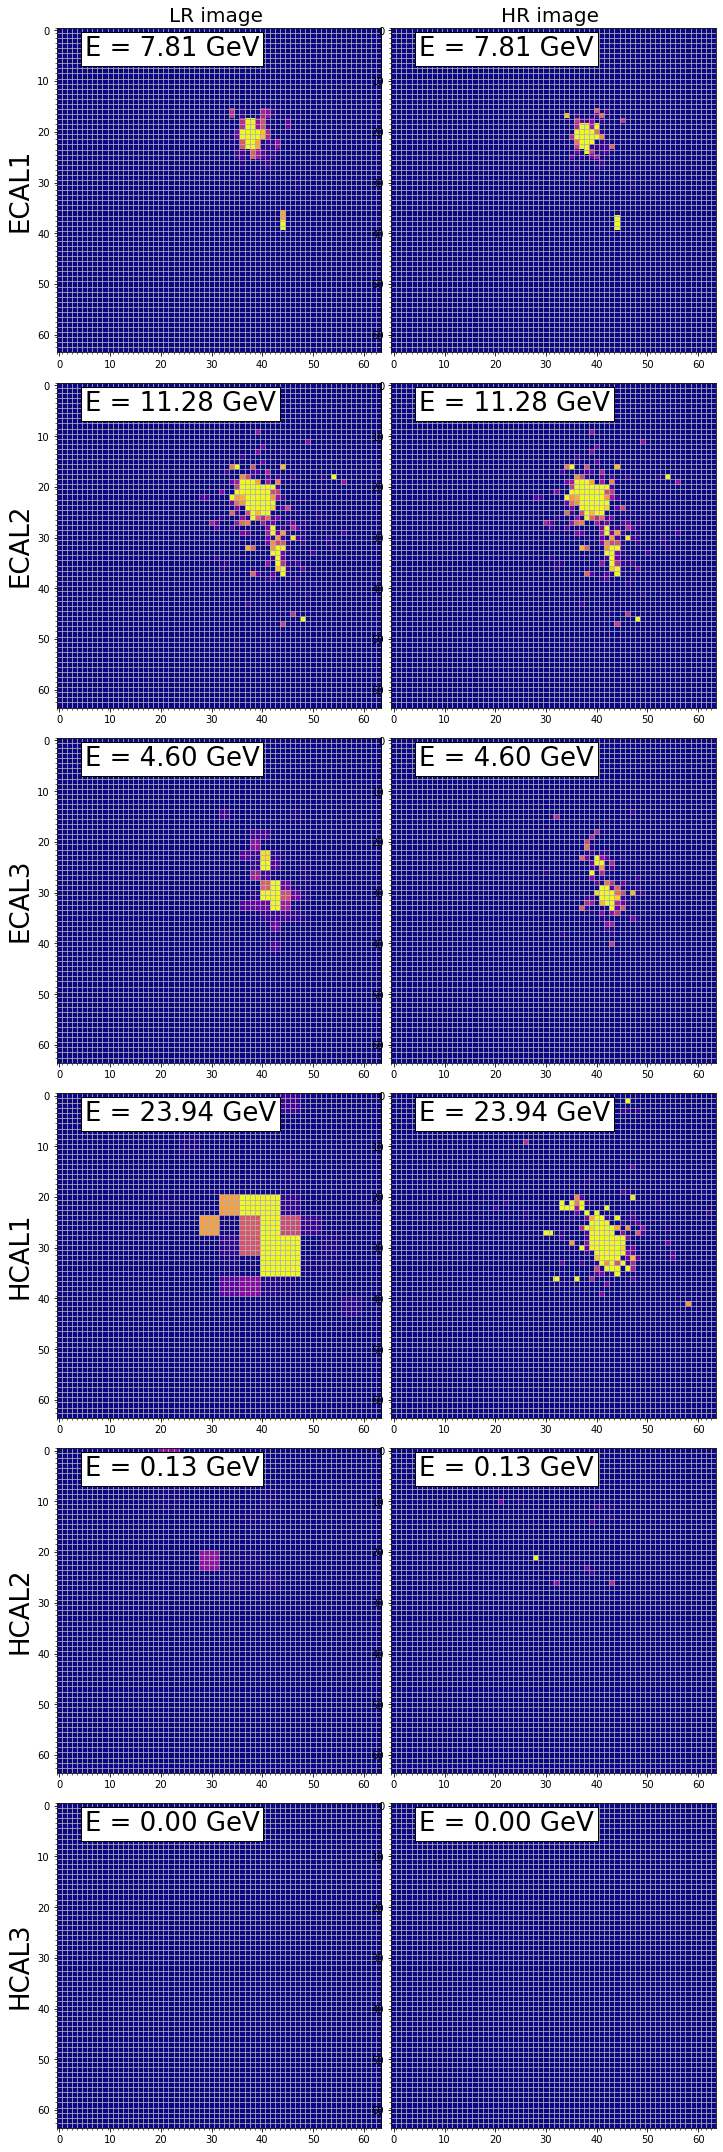

In [83]:
DrawEventSR(train_dataset, event_number = 143)

### Model

In the first implementation, we are using democratic interpulation, from varying detector granularity to a fixed size images of $6\times 64 \times 64$. The resulting image we will process through a model to recover the $HR$ image.

In [7]:
device_number = 0; #change this value to "1" if using the second GPU
use_cuda = torch.cuda.is_available()
print('Availability of CUDA:',use_cuda)
print('Availability of CUNN:',torch.backends.cudnn.enabled)
print('Total number of GPU devices: ',torch.cuda.device_count())
device = torch.device("cuda:"+str(device_number) if torch.cuda.is_available() else "cpu")
if use_cuda:
    torch.cuda.set_device(device_number)
    idevice = torch.cuda.current_device()
    print('Will work on device number',idevice,', named: ',torch.cuda.get_device_name(idevice))
else: print('will run on CPU, using',torch.get_num_threads(),'cores')

Availability of CUDA: False
Availability of CUNN: True
Total number of GPU devices:  0
will run on CPU, using 8 cores


In [110]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 5, padding=2,bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 5, padding=2,bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        out = self.conv(x)
        return torch.cat([x, out],dim=1)

class SRnet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(SRnet, self).__init__()
        self.conv1 = double_conv(n_channels, n_channels)
        self.conv2 = double_conv(2 * n_channels, n_channels)
        self.conv3 = double_conv(3 * n_channels, n_channels)
        self.outc  = double_conv(4 * n_channels, n_classes)

    def forward(self, x):
        initial_energy = x.sum(dim=(2,3)).unsqueeze_(2).unsqueeze_(3)
        print('input.shape',x.shape)
        x1 = self.conv1(x)
        print('x1.shape',x1.shape)
        x2 = self.conv2(x1)
        print('x2.shape',x2.shape)
        x3 = self.conv3(x2)
        print('x3.shape',x3.shape)
        x = self.outc(x3)
        print('x4.shape',x.shape)
        final_energy = x.sum(dim=(2,3)).unsqueeze_(2).unsqueeze_(3)
        final_energy[final_energy==0] = 1
        scale = initial_energy/final_energy
        return x * scale

In [111]:
model = SRnet(6,6)

In [112]:
print('model parameters = ',sum(p.numel() for p in model.parameters() if p.requires_grad))

model parameters =  12696


### Prepare the trainer and tester


In [113]:
from train_helpers import trainMe, CreateCash

### Loss function:

For this task, a MSELoss will be used

In [114]:
criterion = nn.MSELoss()
#def criterion(yhat, y):
#    vec = (yhat - y).pow(2)
#    print('yhat=',yhat.sum(),'y=',y.sum())
#    return  torch.mean( vec ) 


In [13]:
train_loader=DataLoader(dataset=train_dataset,batch_size=516 ) #train_size
optimizer = optim.Adam(model.parameters(), lr = 0.05)
cacheSR = CreateCash(model)

Train the model

In [14]:
import time
from train_helpers import printProgressBar

def trainMe2(train_loader, model, optimizer, criterion, epochs=1000, cache={'loss':[]}, device=torch.device("cpu")):
    print('len of cache is = ',len(cache['loss']))
    isGPU = torch.cuda.is_available() and 'cuda'==device.type
    if isGPU and not next(model.parameters()).is_cuda:
        print('copy the model to GPU')
        model.to(device)
    tic = time.time()
    for epoch in range(epochs):
        for x, y in train_loader:
            print('x.shape',x.shape)
            print('y.shape',y.shape)
            x = x.reshape((x.shape[0],6,64,64))
            y = y.reshape((y.shape[0],6,64,64))
            print('x.shape',x.shape)
            print('y.shape',y.shape)
            if isGPU:
                if isinstance(x,type([])):
                    x = [k.to(device) for k in x]
                else: x = x.to(device)
                y = y.to(device)
            loss=criterion(model(x),y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        cache['loss'].append(loss.item())
        printProgressBar(epoch, epochs, loss.item())
    toc = time.time()
    print('total time: %2.2f sec' %(toc-tic))
    if isGPU:
        print('cached',torch.cuda.memory_cached(device)/1e6,' MB')
        torch.cuda.empty_cache() 
        print('Cache cleaned\nRemaining cached memory',torch.cuda.memory_cached(device)/1e6,' MB')
    return  cache

In [ ]:
# training the model
cacheSR = trainMe2(train_loader, model, optimizer, criterion, 10, cacheSR, device)

#saving the model
torch.save({
    'model_state_dict' : model.cpu().state_dict(),
    'cache' : cacheSR,
    },
    'models/UNET_SR_dipion_dict_v1.pt')

In [25]:
#on colab, download the generated sample
files.download('models/UNET_SR_dipion_dict_v1.pt')  

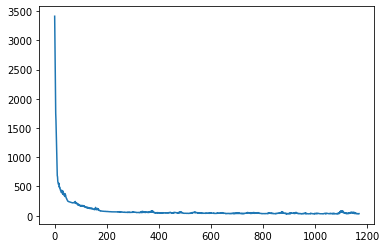

In [27]:
plt.plot(cacheSR['loss'])
plt.show()

### Continue training the model

with different learning rate

In [ ]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 0.025
cacheSR = trainMe2(train_loader, model, optimizer, criterion, 120, cacheSR, device)
plt.plot(cacheSR['loss'])
plt.show()

# Ploting the results

Now we will plot the obtained results of the SR images. The results will be later tested in the downstream task.

In case we have newly trained model, we would like first to load the trained weights:

In [26]:
#load model
checkpoint = torch.load('models/UNET_SR_dipion_dict_v1.pt')
model.load_state_dict(checkpoint['model_state_dict'])
cacheSR = checkpoint['cache']
model.train()
print('model loaded')

model loaded


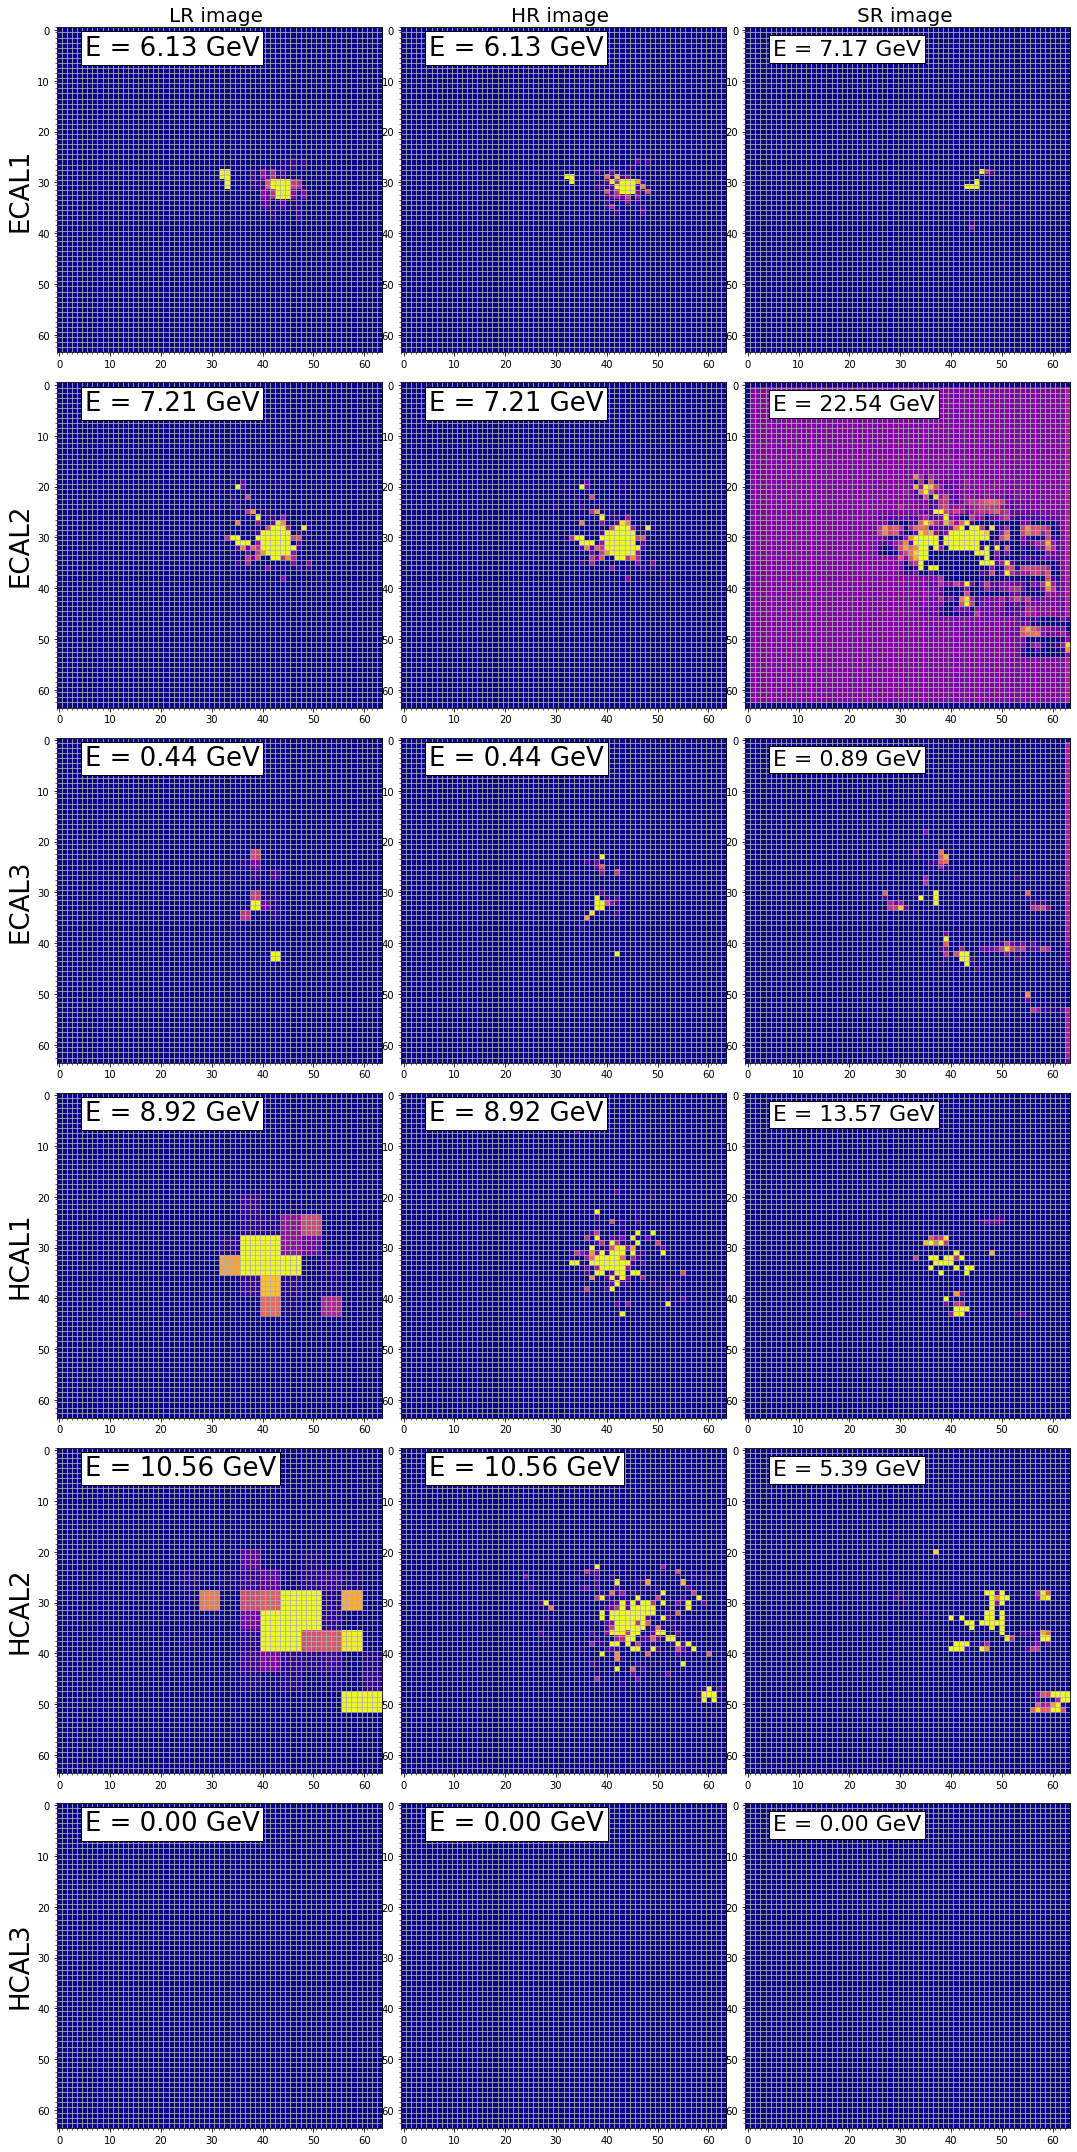

In [28]:
DrawEventSR(train_dataset, event_number = 200, model = model)